# Exercise 1
# Running a single-column sea ice model - Icepack

* **Description**: Instructions for running Icepack with an atmospheric forcing derived from the Atmospheric Radiation Measurement (ARM) program's North Slope of Alaska (NSA) facility and exploring the output.
* **Creator**: David Clemens-Sewall
* **Date**: March 2025

## Background

### Sea ice models
Sea ice models simulate the physical processes which cause the ice to change over time. For regional to global scale sea ice models, it can be helpful to separate these processes into two categories based on the spatial scales of mass movement:
 + Dynamics: processes that move matter (ice) at scales of kilometers and greater. For sea ice models on Eulerian grids (including CICE), these processes move ice horizontally between adjacent grid cells (whose horizontal dimensions are typically on the order of 5-100 km). Simulating these processes requires concurrent information (e.g., ice strength) from many grid-cells.
 + Column-physics: processes that move matter on scales of centimeters to meters. Examples include, sea ice growth/melt and ridge formation. These processes can be simulated within each grid cell without needing information from other grid cells.
The different spatial scales of processes translates nicely into how the CICE sea ice model is implemented in code. The main CICE code handles the dynamics. Meanwhile, a submodule named Icepack simulates the column-physics within each grid cell. In this exercise, we run Icepack by itself as a single-column model* to simulate the specific ice floe that we made field observations on.

### Forcing
Icepack simulates how the ice within its domain changes (e.g., grows) in response to inputs--a.k.a. 'forcing'--from the atmosphere and the ocean. Icepack also simulates the turbulent exchanges at the air-ice and ice-ocean interfaces. For the atmosphere, the required forcing variables are time-resolved near-surface (e.g., 2 meter height) air temperature, specific humidity, wind speed, downwelling longwave (thermal radiation), downwelling shortwave (sunlight), and precipitation (e.g., snowfall rates). The variables are measured in Utqiaġvik at the Department of Energy's Atmospheric Radiation Measurement site, and are provided in the file `icepack_activities/data/sikumiut_MDF_20241001_20250325.nc`. For the ocean, Icepack can simulate the temperature evolution of a very simple ocean mixed layer (the uppermost layer of ocean, which is typically 10-100 m thick and has vertically-uniform temperature and salinity due to mixing). The required forcing variables are the mixed layer salinity, the mixed layer thickness, and the rate of oceanic heat flux convergence into the mixed layer. These variables tend not to vary in time as much as the atmospheric variables, so for simplicity we will specify constant values in the namelist**.

### Ice Thickness Distribution
Some variables, such as air temperature, are sufficiently uniform within each grid cell that an Earth System Model can represent the entire grid cell with a single, average value. This approach does not work well for variables that have high spatial variability and nonlinear effects, such as ice thickness. For example, consider two hypothetical grid cells: the surface area of grid cell A is entirely covered of 2-m-thick ice (~6 ft), meanwhile half of the area of grid cell B is covered in 4-m-thick ice and the other half is open water. The two grid cells have the same average ice thickness (2 m), but have very different properties. In winter, grid cell B will grow ice at faster rate than grid cell A, because ice grows more rapidly in open water than beneath existing ice. However, grid cell A will be more resistant to horizontal compression than grid cell B. Icepack addresses this challenge by explicitly representing an ice thickness distribution (ITD). In the ITD, the ice within a grid cell is represented by multiple (typically 5) 'ice thickness categories' and an area of open water, each of which comprises a fraction of the grid cell area. The ice thickness categories are referred to as 'categories' or 'classes'. They are defined such that the mean ice thickness within a category falls within a set of predefined bounds (e.g., 0.6 m to 1.4 m for category 2). Icepack simulates the vertical thermodynamics (see below) for each category independent of the others. There are also procedures for redistributing ice area and mass between categories (e.g., when open water freezes that area moves from the open water category to category 1).

### Vertical thermodynamics
Icepack simulates the evolution of profiles of heat (temperature) and salt through the snow and sea ice column within each thickness category. Multiple layers within the ice and snow can be represented, and the properties of those layers change due to simulated heat diffusion, brine advection, and the absorption of shortwave radiation. In the standard configuration, snow accumulates on each category based on the precipitation rate (which is uniform for the entire grid cell) and is lost due to sublimation, melting, and snow-ice formation.

### Other processes
Icepack can represent many processes, including ridge formation, melt ponds, biogeochemistry, and others. See the [documentation](https://cice-consortium-icepack.readthedocs.io/en/main/science_guide/index.html)
_______________________________________________________________________________
*The 'single-column' nomenclature refers to the fact that the model does not simulate horizontal fluxes between adjacent grid cells (since there are no adjacent grid cells). For sea ice models that include an ice thickness distribution, this nomenclature can be somewhat confusing.

**The 'namelist' is a file that contains instructions for the model on how to set up the simulation, how long to simulate for, what forcing data to use, and similar information.

![title](zampieri_icepack_graphic.png)
Figure 1. Schematic of how Icepack represents the sea ice cover, highlighting the ice thickness distribution categories (Open Water, Class 1, Class 2, etc...) and some of the physical processes (e.g., vertical distribution of ice temperature and salinity). Figure credit Lorenzo Zampieri.

## Install and run Icepack

0) Icepack has been run successfully on Linux, Mac, Windows Subsystem for Linux, and in Docker containers. If you have access to any of those OS's, please follow the instructions below and let David know if you run into any issues.

1) Install Icepack following the directions in the Icepack documentation: https://cice-consortium-icepack.readthedocs.io/en/main/user_guide/ug_running.html#porting-to-laptop-or-personal-computers

2) Within ~/icepack-dirs/input/Icepack_data/forcing/ create a subdirectory named 'MDF'. Copy the file `sikumiut_MDF_20241001_20250325.nc` from the sikumiut/icepack_activities/data into the MDF directory.

3) The MDF forcing option may not have been merged into the CICE Consortium's branch of Icepack by the time you are downloading Icepack. If not, add David's fork of Icepack (git@github.com:davidclemenssewall/Icepack.git) as an alternate remote and pull the branch `mosaic_forcing_clean`.

4) From the Icepack root directory, setup an Icepack case using the settings `ionetcdf,histcdf`. E.g.: `./icepack.setup -m conda -e linux -c ~/icepack-dirs/cases/sikumiut_elson_base -s ionetcdf,histcdf`

5) Navigate to that case directory. Build Icepack with the `./icepack.build` command. You should see Icepack compile.

6) Make the following edits to the icepack_in file:
```
    use_leap_years = .true.
    year_init      = 2024
    istep0         = 6960
    npt            = 3792
    
	hmix_fixed      = 3.0
	atm_data_type   = 'MDF'
	ocn_data_type   = 'default'
	fyear_init		= 2024
	atm_data_file   = 'sikumiut_MDF_20241001_20250325.nc'
    ice_data_file   = 'unknown_ice_data_file'
    atm_data_format = 'nc'
	precalc_forc  = .true.
```
Explanations:

istep0: What timestep, counting from midnight January 1 of `year_init`, to begin the simulation at. In this case, because our timestep is one hour (`dt = 3600.0` seconds) 6,960 hours into the year 2024 corresponds to October 17, 2024. This is the day that Michael Lawson reported satellite imagery showing ice in Elson Lagoon. You might consider changing istep0 if you had information that freeze-up started earlier.

npt: The number of timesteps to simulate. In this case our forcing data goes until March 24, so it is the number of hours between March 24, 2025 and October 17, 2024.

hmix_fixed: the depth of the ocean mixed layer in m, in the case of Elson this is just 3 m.

atm_data_type: MDF is the option to use the MDF-formatted netCDF forcing file

ocn_data_type: set this to default to prevent an ocean forcing file from being used. We can set the ocean parameters with 
sss_mixed, qdp_fixed, hmix_fixed, and ustar_min.

atm_data_file: The atmospheric forcing from the ARM site.

ice_data_file: reset this so that the SHEBA dynamics forcing is not used.

atm_data_format: Our forcing is a netCDF file.

precalc_forc: Using a MDF forcing requires us to precalculate the forcing data at the model's timesteps.

7) Run Icepack with the command `./icepack.submit`. You should see ICEPACK COMPLETED SUCCESSFULLY

## Examine Icepack output

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# icepacktools is a small library containing functions to make it easier
# to work with Icepack output
from icepacktools import load_icepack_hist, plot_handler

In [38]:
# Load Icepack output
ip_dirs_path = "/home/dcsewall/code/docker_icepack_interactive/icepack-dirs"
run_dict = {"sikumiut_nearshore_bestfit": None,
            }

hist_dict = {}
for key, value in run_dict.items():
    hist_dict[key] = load_icepack_hist(run_name=key, 
                                       icepack_dirs_path=ip_dirs_path, 
                                       hist_filename=value,
                                       snhf=True)
    hist_dict[key]['flwnet'] = hist_dict[key]['flw'] + hist_dict[key]['flwout']


In [3]:
# The cell above uses the function `load_icepack_hist` to read in the Icepack
# output. To learn more about a function, we can use the `help(...)` command:
help(load_icepack_hist)

Help on function load_icepack_hist in module icepacktools:

load_icepack_hist(run_name, icepack_dirs_path, hist_filename=None, sst_above_frz=True, volp=False, snhf=False, pnd_budget=False, trcr_dict=None, trcrn_dict=None)
    Load Icepack history output
    
    Parameters
    ----------
    run_name : str
        Name of the icepack run (directory name in RUN_DIR)
    icepack_dirs_path : str
        Path to root of icepack directory.
    hist_filename : str or None, optional
        Name of specific history file to load. If None load the first file 
        in history directory. Default is None.
    sst_above_frz : bool, optional
        Whether or not to compute the difference between mixed layer freezing 
        point and temperature. Default is True.
    volp : bool, optional
        Whether or not to compute the pond volume per grid cell area (units m).
        requires alvl and alvln tracers. Default is False.
    snhf : bool, optional
        Whether or not to compute the net s

In [27]:
# Snow depth and ice thickness data

# The following snow data for site A is from Anika Pinzner (UAF). When you have
# measured snow depths and ice thicknesses, include them in this dataframe.

measurement_dates = np.array(['2025-02-28', # Add your measurement date here
                             ], dtype='datetime64')

# All units are in meters, columns are:
# mean hi, sem hi, mean hs, sem hs
# where hi is ice thickness and hs is snow depth. 
# sem is standard error of the mean
data = np.array([[1.55, np.nan, 0.03, np.nan],
                 ]) # add your data as another row

# code for constructing pandas DataFrame
ind = pd.MultiIndex.from_product([['A'], measurement_dates], 
                                 names=['site', 'time'])
col = pd.MultiIndex.from_product([['hi', 'hs'], ['mean', 'sem']])
df_ice = pd.DataFrame(data, index=ind, columns=col)
for col in df_ice.columns:
    if col[1] == 'sem':
        df_ice[(col[0], 'semx2')] = df_ice[col]*2

In [28]:
# Examine the structure of this DataFrame
df_ice

hi        hs        hi    hs
                 mean sem  mean sem semx2 semx2
site time                                      
A    2025-02-28  1.55 NaN  0.03 NaN   NaN   NaN

In [42]:
# Examine the contents of an icepack history file
hist_dict["sikumiut_nearshore_bestfit"]

<xarray.Dataset>
Dimensions:        (ni: 4, ncat: 5, ntrcr: 21, time: 3072)
Coordinates:
  * ni             (ni) int32 1 2 3 4
  * ncat           (ncat) int32 1 2 3 4 5
  * ntrcr          (ntrcr) int32 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
  * time           (time) datetime64[ns] 2024-11-16T01:00:00 ... 2025-03-24
Data variables: (12/42)
    timestep       (time) int32 ...
    date           (time) float64 ...
    aice           (time, ni) float64 ...
    vice           (time, ni) float64 ...
    vsno           (time, ni) float64 ...
    uvel           (time, ni) float64 ...
    ...             ...
    vsnon          (time, ncat, ni) float64 ...
    trcr           (time, ntrcr, ni) float64 ...
    trcrn          (time, ncat, ntrcr, ni) float64 ...
    sst_above_frz  (time, ni) float64 0.0 0.0 0.0 1.616 ... 0.0366 0.03588 1.616
    snhf           (time, ni) float64 249.1 -47.6 -10.01 ... -15.74 -9.029 167.3
    flwnet         (time, ni) float64 249.1 -12.07 -7.623 ... -60.75 -59.6 167.3
Attributes:
    run_name:  sikumiut_nearshore_bestfit

## Icepack history files
Icepack history files are netCDF files containing the full Icepack output from a given run. The output has four dimensions:
 + ni: By default Icepack runs a simulation for four independent grid cells, all with the same forcing and parameterization options. Cell 1 (`ni = 1`) is initialized with 100% open water. Cell 2 is initialized with 100% ice cover all with the same thickness (set by the namelist parameter `hi_init_slab`). Cell 3 is initialized with 100% ice cover with different thicknesses and area fractions for each category (controlled by the parameter `hbar_init_itd`). Cell 4 is a land cell, and should never contain any ice (it is present for code testing).
 + ncat: This dimension is for the different ice thickness categories within each grid cell. `ncat = 1` is the thinnest ice category and `ncat = 5` is the thickest.
 + ntrcr: Icepack outputs all of the tracer values at each timestep, so quantities that are simulated but are not part of the standard output can be examined. Ask David if you are interested in how to work with this information.
 + time

Most of the standard data variables are grid cell averages. Data variables include both ice state terms (e.g., vice is mean ice thickness), fluxes (e.g., fsens is the sensible heat flux from the atmosphere to the ice), and ice mass balance terms (e.g., congel is the congelation growth rate). Data variables that end in 'n' (e.g., vicen) are per-category values. Vicen and vsnon are both volumes per unit grid cell area, such that `sum(vicen) = vice`. So to get the ice thickness for each category one would divide vicen by aicen. Data variable names are not always intuitive, so please ask David specific questions about the identity of specific variables and/or what is present.

In [30]:
# Create mapping between Icepack variable names and measurement names

# This dictionary contains the correspondence between variable names in 
# Icepack output (the keys) with variable names in our df_ice DataFrame
# (the values). Because we might measure the same variable in multiple ways
# (e.g., drilled and EM ice thickness), the values are lists.
ice_var_map = {'vice': ['hi'],
               'vsno': ['hs'],
               }

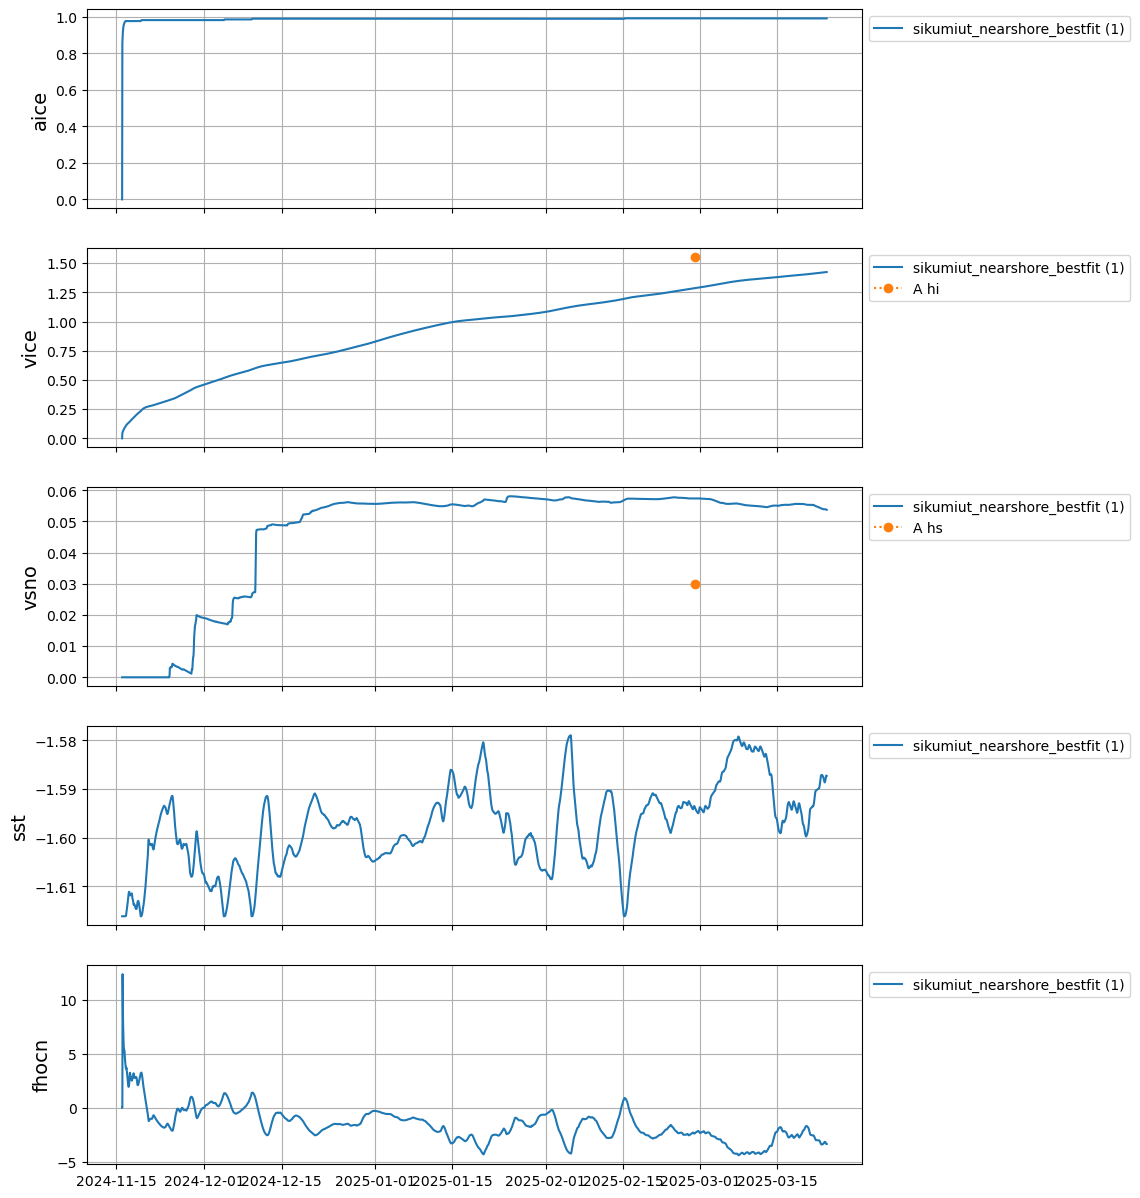

In [39]:
# Plot ice state evolution

# In this dictionary, the key is the name of the run to plot and the
# value is which grid cells (1, 2, 3, and/or 4) to plot
run_plot_dict = {"sikumiut_nearshore_bestfit": [1]}
# These are the names of the data variables to plot 'aice' = ice area fraction
# 'vice' = grid cell mean ice thickness, 'vsno' = grid cell mean snow depth
var_names = ['aice', 'vice', 'vsno', 'sst', 'fhocn']
# This list indicates which field sites to plot
ice_sites = ['A']


f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                      ice_var_map=ice_var_map, 
                      ice_sites=ice_sites,
                      df_ice=df_ice
                     )
plt.show()


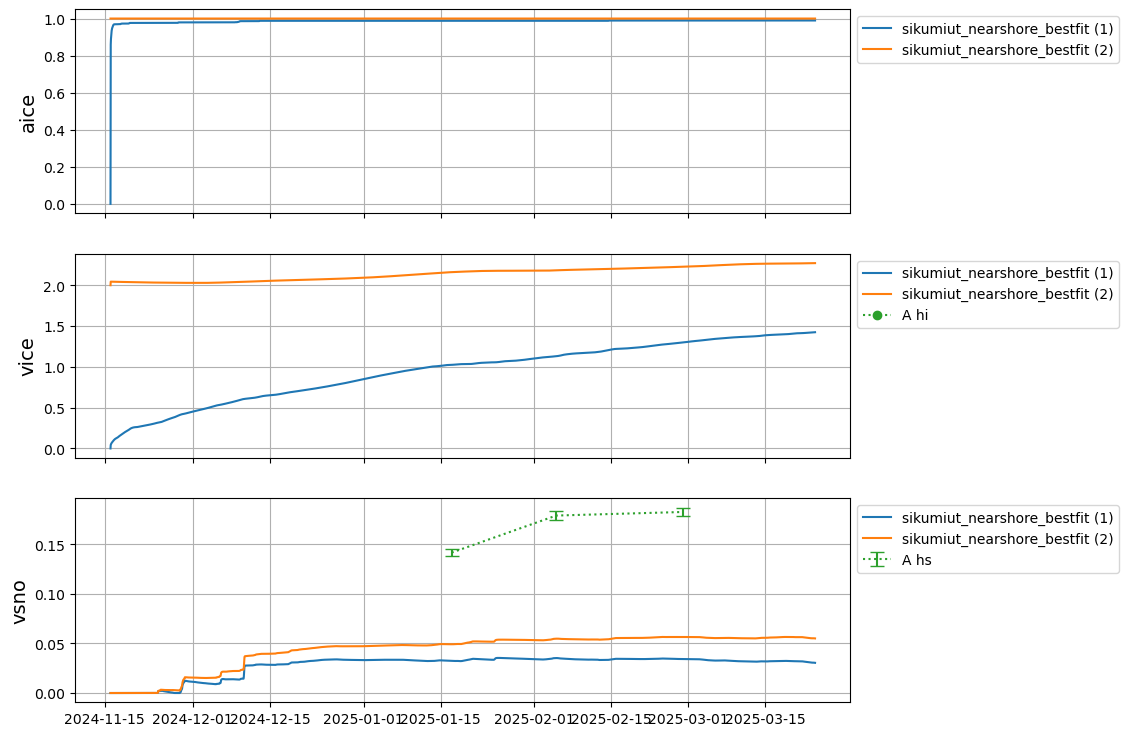

In [20]:
# Plot multiple grid cells

# The `plot_handler` function can plot multiple grid cells simultaneously to
# compare. Here we plot grid cell ni = 2, in which the sea ice is initialized
# as a uniform slab of 2 m thick ice, and ni = 1 (initialized open water).

# Note that for grid cell 2, Icepack is simulating what would have happened
# if the ice were initially 2 m thick in October AND the atmospheric forcing
# was exactly the same as what was observed. This is critically different from
# simulating what would have happened if the ice were initially 2 m thick in
# October. In the latter case, the thicker ice would have caused changes in
# the heat flux to the atmosphere, which then would have provided a different
# forcing to the ice. Studying this kind of feedback requires a coupled model,
# one in which the atmosphere and ice are both being simulated concurrently and
# can impact one another.

# In this dictionary, the key is the name of the run to plot and the
# value is which grid cells (1, 2, 3, and/or 4) to plot
run_plot_dict = {"sikumiut_nearshore_bestfit": [1, 2]}
var_names = ['aice', 'vice', 'vsno']
ice_sites = ['A']


f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                      ice_var_map=ice_var_map, ice_sites=ice_sites,
                      df_ice=df_ice)
plt.show()


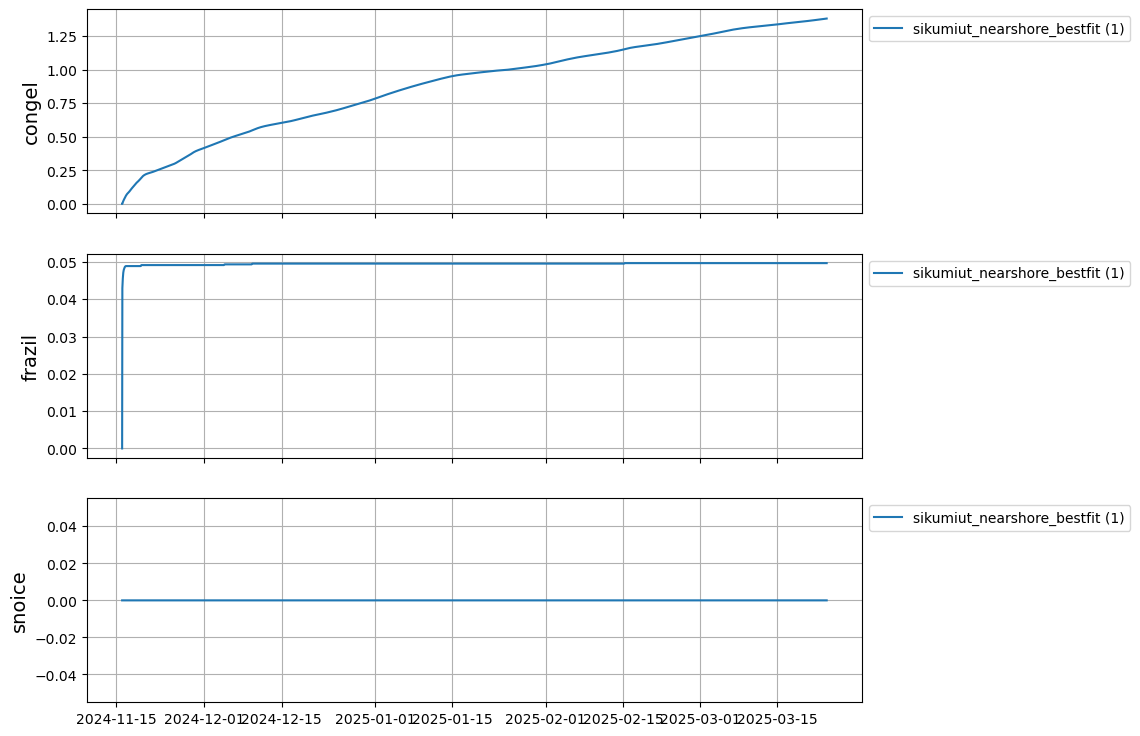

In [40]:
# Plot cumulative variables

# Sometimes it is more convenient to look at the cumulative sum of a variable, 
# such as for the ice mass balance terms (e.g., congelation growth)

run_plot_dict = {"sikumiut_nearshore_bestfit": [1]}
# congel = congelation growth rate, frazil = frazil growth rate,
# snoice = snow-ice growth rate
# the units of these rate terms are meters per model timestep
# so their cumulative sum is the same as the vice evolution above.
var_names = ['congel', 'frazil', 'snoice']


f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                      cumulative=True)
plt.show()

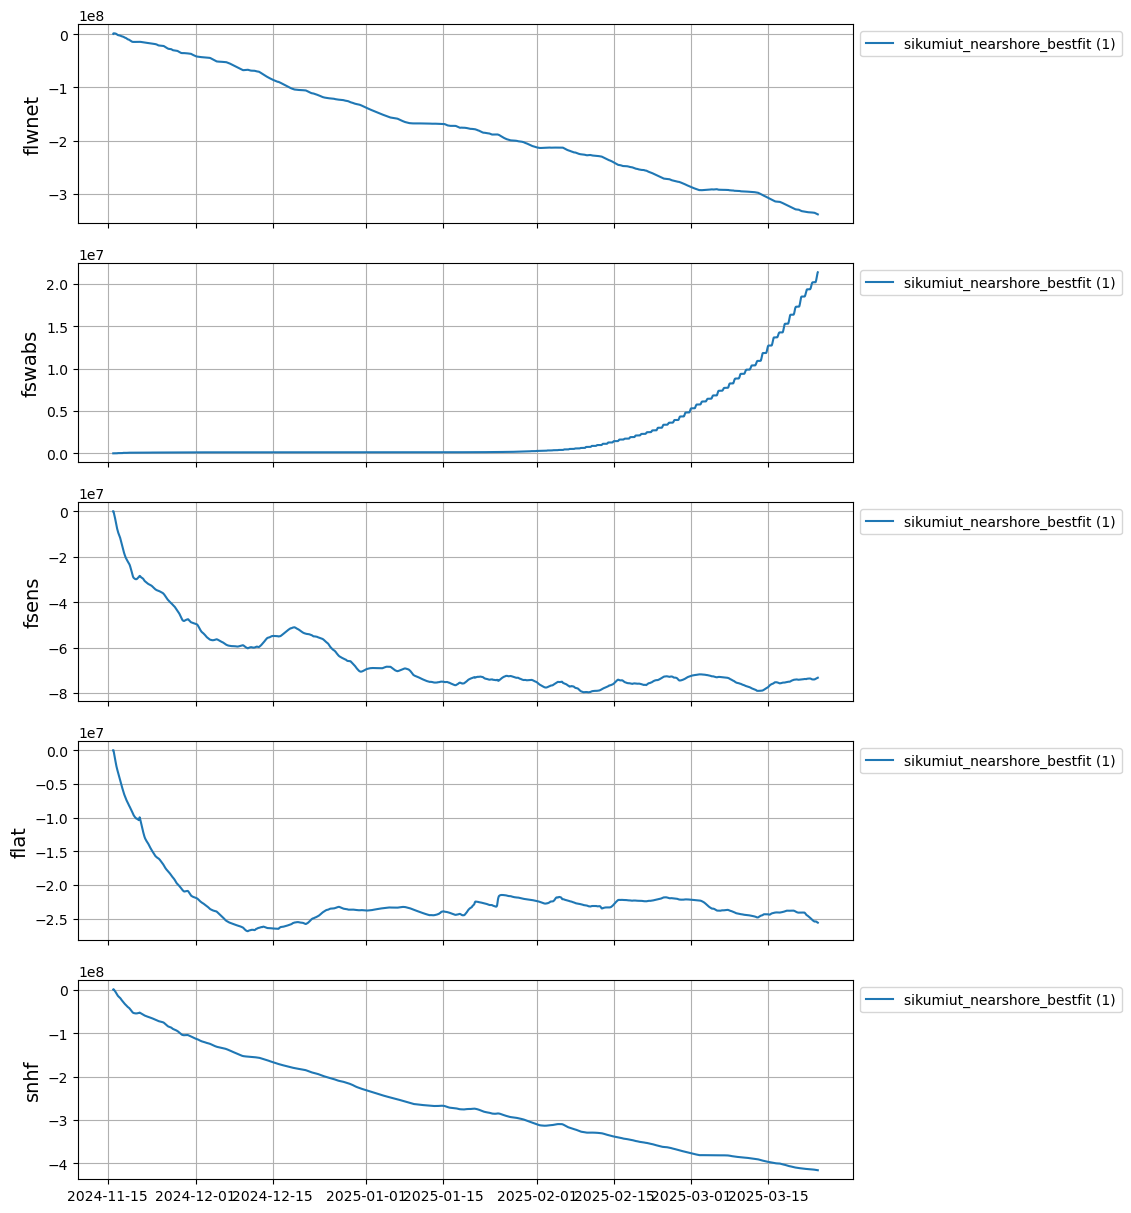

In [41]:
# Plot surface energy fluxes

# Surface energy fluxes can also be useful to examine cumulatively
# However, they are in units of W/m2. To convert the cumulative flux into
# J/m2, we need to multiply them by the number of seconds in each timestep
# This is done in the plot_handler by setting `mult=3600.0` below.

run_plot_dict = {"sikumiut_nearshore_bestfit": [1]}
# flwnet = net longwave
# fswabs = absorbed shortwave
# fsens  = turbulent sensible heat flux
# flat   = turbulent latent heat flux
# snhf   = 'surface net heat flux' (the sum of the above terms)
# Positive fluxes correspond to energy gained by the snow and ice cover
# negative fluxes correspond to energy lost to the atmosphere
var_names = ['flwnet', 'fswabs', 'fsens', 'flat', 'snhf']

f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                      cumulative=True, mult=3600.0)
plt.show()

# Note the scales of the y-axes!

## Exploration and discussion

Now explore features that you find interesting in the Icepack simulation. Below are some questions that you can consider to get started, but feel free to explore what you find interesting (no need to answer the questions, this is not a test).

Potential questions:
 + Plot additional variables. 
 + What parameters are you interested in learning more about?
 + Does the simulated ice thickness align with your measurements? If not, consider reasons for the discrepancy.
 + What are features of the ice that you would like a model to be able to simulate? Can Icepack simulate them?
 + In mid-January, the modeled ice growth rate drops from about 20 cm/month to around 10 cm/month. What caused the change?
 + Why was the simulated snow depth and ice thickness evolution so different for ice that was initially 2 m thick (`ni = 2`) compared to the ice grown from open water (`ni = 1`)?